Content

1.  Import data set

2.  Consider any security implications that might exist for this new data. You’ll need to address any PII data in the data before         continuing your analysis.

3.1 Create a regional segmentation of the data. You’ll need to create a “Region” column based on the “State” column from your         customers data set.

3.2 Determine whether there’s a difference in spending habits between the different U.S. regions. 

4.  Create an exclusion flag for low-activity customers (customers with less than 5 orders) and exclude them from the data. Make sure       you export this sample.

5.  Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependants.

6.  Create an appropriate visualization to show the distribution of profiles.

7.1 Aggregate the max, mean, and min variables on a customer-profile level for usage frequency.

7.2 Aggregate the max, mean, and min variables on a customer-profile level for expenditure.

8.  Compare your customer profiles with regions and departments. Can you identify a link between them? Customers may demonstrate           different behaviors across regions, which could make this information important.

In [1]:
# import library
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# 1. Import data set

In [2]:
customer_merged = pd.read_pickle(r'D:\ドキュメント\Jupyter\CareerFoundry Achievement 4\02 Data\Prepared Data\customer_merged_with_grouped.pkl')

In [3]:
# show all column
pd.set_option('display.max_columns', 50)

#  2. Consider any security implications that might exist for this new data. You’ll need to address any PII data in the data before continuing your analysis.

PII data: First Name, Surname, Gender

In [4]:
removed_pii = customer_merged.drop(columns = ['eval_set','_merge','First Name','Surnam','Gender'])

# 3.1 Create a regional segmentation of the data. You’ll need to create a “Region” column based on the “State” column from your customers data set.

Region 1 = Maine, New Hampshire, Vermont, Massachusetts, Rhode Island, Connecticut, New York, Pennsylvania, New Jersey

Region 2 = Wisconsin, Michigan, Illinois, Indiana, Ohio, North Dakota, South Dakota, Nebraska, Kansas, Minnesota, Iowa, Missouri

Region 3 = Delaware, Maryland, District of Columbia, Virginia, West Virginia, North Carolina, South Carolina, Georgia, Florida, Kentucky, Tennessee, Mississippi, Alabama, Oklahoma, Texas, Arkansas, Louisiana

Region 4 = Idaho, Montana, Wyoming, Nevada, Utah, Colorado, Arizona, New Mexico, Alaska, Washington, Oregon, California, Hawaii

In [5]:
result = []
# making new column for state flag
for value in customer_merged["STATE"]:
    if (value == "Maine" or value=="New Hampshire" or value=="Vermont" or value=="Massachusetts" or value=="Rhode Island" or value=="Connecticut" or value=="New York" or value=="Pennsylvania" or value=="New Jersey"):
        result.append("Northeast")
    elif (value == "Wisconsin" or value=="Michigan" or value=="Illinois" or value=="Indiana" or value=="Ohio" or value=="North Dakota" or value=="South Dakota" or value=="Nebraska" or value=="Kansas" or value=="Minnesota" or value=="Iowa" or value=="Missouri"):
        result.append("Midwest")
    elif (value == "Delaware" or value== "Maryland" or value== "District of Columbia" or value== "Virginia" or value== "West Virginia" or value== "North Carolina" or value== "South Carolina" or value== "Georgia" or value== "Florida" or value== "Kentucky" or value== "Tennessee" or value== "Mississippi" or value== "Alabama" or value== "Oklahoma" or value== "Texas" or value== "Arkansas" or value== "Louisiana"):
        result.append("South")
    elif (value == "Idaho" or value== "Montana" or value== "Wyoming" or value== "Nevada" or value== "Utah" or value== "Colorado" or value== "Arizona" or value== "New Mexico" or value== "Alaska" or value== "Washington" or value== "Oregon" or value== "California" or value== "Hawaii"):
        result.append("West")
    else:
        result.append("Not Enough Data")

removed_pii['Country_Region'] = result

In [6]:
# count number of country regions
removed_pii['Country_Region'].value_counts(dropna = False)

South        10801982
West          8300617
Midwest       7604016
Northeast     5728444
Name: Country_Region, dtype: int64

# 3.2 Determine whether there’s a difference in spending habits between the different U.S. regions. 

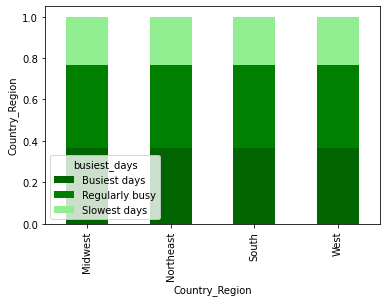

In [9]:
# compare when they use the shop in a week by regions
crosstab_3 = pd.crosstab(removed_pii['Country_Region'], removed_pii['busiest_days'],normalize="index")
ax = plt.subplot()
crosstab_3.plot.bar(stacked=True, color=['darkgreen','green','lightgreen'], ax=ax)
ax.set_ylabel('Country_Region')
plt.show()
ax.figure.savefig(r'D:\ドキュメント\Jupyter\CareerFoundry Achievement 4\04 Analysis\Visualizations\region_habit1.png',bbox_inches="tight")

## There is no difference in spending habits between the different U.S. regions. 

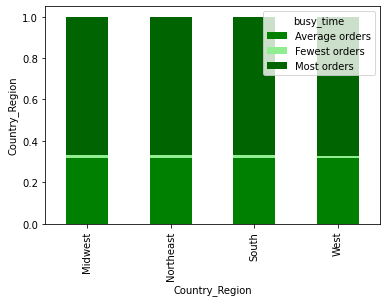

In [12]:
# compare when people use the shop in a day by regions
crosstab_6 = pd.crosstab(removed_pii['Country_Region'], removed_pii['busy_time'],normalize="index")
ax = plt.subplot()
crosstab_6.plot.bar(stacked=True, color=['green','lightgreen','darkgreen'], ax=ax)
ax.set_ylabel('Country_Region')
plt.show()
ax.figure.savefig(r'D:\ドキュメント\Jupyter\CareerFoundry Achievement 4\04 Analysis\Visualizations\region_habit_time1.png',bbox_inches="tight")

## There is no difference in spending habits between the different U.S. regions. 

# 4. Create an exclusion flag for low-activity customers (customers with less than 5 orders) and exclude them from the data. Make sure you export this sample.

In [13]:
# making new column for activity flag
removed_pii.loc[customer_merged['max_order'] < 5, 'low activity flag'] = 'low-activity customer'
removed_pii.loc[customer_merged['max_order'] >= 5, 'low activity flag'] = 'active_customer' 

In [14]:
removed_pii['low activity flag'].value_counts(dropna = False)

active_customer          30993489
low-activity customer     1441570
Name: low activity flag, dtype: int64

In [15]:
# remove low-activity customer
all_order = removed_pii.loc[removed_pii['low activity flag'] == 'active_customer']

In [16]:
# save the exclude version of data set
all_order.to_pickle(r'D:\ドキュメント\Jupyter\CareerFoundry Achievement 4\02 Data\Prepared Data\q_5_all_order.pkl')

# 5.Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependants.

In [17]:
def customer_label(row):
# Create New Column for customer category
  if (row['Age'] < 35) and (row['Number_of_dependents'] == 0):
    return 'Young adult'
  elif (row['Age'] < 35) and (row['Number_of_dependents'] >= 1):
    return 'Young parent'
  elif (row['Age'] >= 35) and (row['Age'] < 55) and (row['Number_of_dependents'] == 0):
    return 'Middle Adult'
  elif (row['Age'] >= 35) and (row['Age'] < 55) and (row['Number_of_dependents'] >= 1):
    return 'Middle Age Parent'
  elif (row['Age'] >= 55) and (row['Number_of_dependents'] == 0):
    return 'Old Adult'
  elif (row['Age'] >= 55) and (row['Number_of_dependents'] >= 1):
    return 'Old Age Parent'
  else: return 'Not enough data'
    
all_order['Customer_Category'] = all_order.apply(customer_label, axis=1)

<ipython-input-17-c037934508ab>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_order['Customer_Category'] = all_order.apply(customer_label, axis=1)


In [18]:
all_order['Customer_Category'].value_counts()

Old Age Parent       9733045
Middle Age Parent    7328810
Young parent         6184451
Old Adult            3277106
Middle Adult         2404509
Young adult          2065568
Name: Customer_Category, dtype: int64

In [19]:
def income_label(row):
# create new column for income rage
  if (row['income'] < 70000):
    return 'Lower_income'
  elif (row['income'] >= 70000) and (row['income'] <= 120000):
    return 'Middle_income'
  elif (row['income'] > 120000):
    return 'higher_income'
  else: return 'Not enough data'
    
all_order['income_range'] = all_order.apply(income_label, axis=1)

<ipython-input-19-22f945d7e223>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_order['income_range'] = all_order.apply(income_label, axis=1)


In [20]:
all_order['income_range'].value_counts()

Middle_income    13276833
higher_income     9187614
Lower_income      8529042
Name: income_range, dtype: int64

# 6. Create an appropriate visualization to show the distribution of profiles.

<AxesSubplot:>

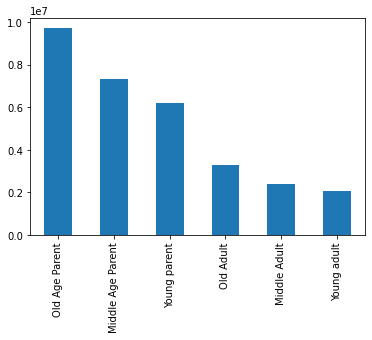

In [21]:
all_order['Customer_Category'].value_counts().plot.bar()

Old age parent has the highest number of order

# 7.1 Aggregate the max, mean, and min variables on a customer-profile level for usage frequency.

In [22]:
all_order.groupby('Customer_Category').agg({'days_since_prior_order': ['mean','max','min']})

days_since_prior_order           
                                    mean   max  min
Customer_Category                                  
Middle Adult                   10.829452  30.0  0.0
Middle Age Parent              10.806823  30.0  0.0
Old Adult                      10.731785  30.0  0.0
Old Age Parent                 10.861811  30.0  0.0
Young adult                    10.906971  30.0  0.0
Young parent                   10.816133  30.0  0.0

There is no specific diffrence between customer category interm of average of days since prior order

# 7.2 Aggregate the max, mean, and min variables on a customer-profile level for expenditure.

In [23]:
all_order.groupby('Customer_Category').agg({'Average_spending': ['mean','max','min']})

Average_spending                        
                              mean           max       min
Customer_Category                                         
Middle Adult             12.488241  15006.940000  1.000000
Middle Age Parent        11.490561   6983.593023  1.000000
Old Adult                11.760842  14042.512281  1.308333
Old Age Parent           12.015565   7414.485185  1.262500
Young adult              12.190407   8794.882427  1.800000
Young parent             12.110755  10209.987755  1.628571

# 8.Compare your customer profiles with regions and departments. Can you identify a link between them? Customers may demonstrate different behaviors across regions, which could make this information important.

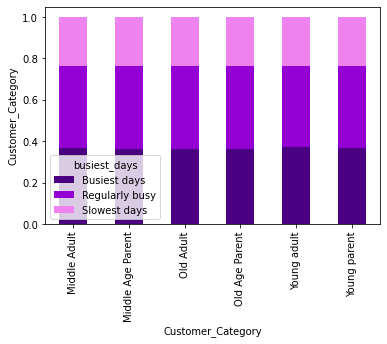

In [24]:
# compare weekly habit by customer categories
crosstab_10 = pd.crosstab(all_order['Customer_Category'], all_order['busiest_days'], normalize="index")
ax = plt.subplot()
crosstab_10.plot.bar(stacked=True, color=['indigo','darkviolet','violet'], ax=ax)
ax.set_ylabel('Customer_Category')
plt.show()
ax.figure.savefig(r'D:\ドキュメント\Jupyter\CareerFoundry Achievement 4\04 Analysis\Visualizations\customer_habit1.png',bbox_inches="tight")

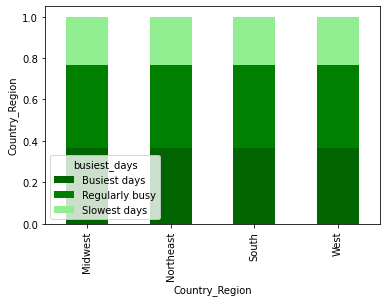

In [25]:
# compare weekly habit by regions
ax = plt.subplot()
crosstab_3.plot.bar(stacked=True, color=['darkgreen','green','lightgreen'], ax=ax)
ax.set_ylabel('Country_Region')
plt.show()
ax.figure.savefig(r'D:\ドキュメント\Jupyter\CareerFoundry Achievement 4\04 Analysis\Visualizations\regions_habit.png',bbox_inches="tight")

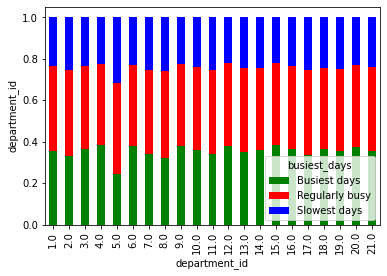

In [27]:
# compare weekly habit by department
crosstab_27 = pd.crosstab(all_order['department_id'], all_order['busiest_days'], normalize="index")
ax = plt.subplot()
crosstab_27.plot.bar(stacked=True, color=['green','red','blue'], ax=ax)
ax.set_ylabel('department_id')
plt.show()
ax.figure.savefig(r'D:\ドキュメント\Jupyter\CareerFoundry Achievement 4\04 Analysis\Visualizations\department_habit.png',bbox_inches="tight")

# The above three graphs show the difference of days of placing the order by customer category, regions and department. The percentage of days of placing order day is almost identical when comparing each customer category, regions and department. The portion of the order on busiest days are the highest. Regularly busy days and slowest days are following by.

In [29]:
# save the exclude version of data set
all_order.to_pickle(r'D:\ドキュメント\Jupyter\CareerFoundry Achievement 4\02 Data\Prepared Data\all_order.pkl')